In [400]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.cluster import hierarchy
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

In [401]:
# @formatter:off
%matplotlib inline
# @formatter:on

In [402]:
sns.set_theme()

plt.rcParams['figure.figsize'] = (9, 5)

# Часть 1. Датасет `beverage_r.csv`

In [403]:
df: pd.DataFrame = pd.read_csv('data/beverage_r.csv', sep=';')
df = df.drop(columns=['numb.obs']).rename(columns={'SEVENUP': '7UP'})
df.head()

,COKE,D_COKE,D_PEPSI,D_7UP,PEPSI,SPRITE,TAB,7UP
0,1,0,0,0,1,1,0,1
1,1,0,0,0,1,0,0,0
2,1,0,0,0,1,0,0,0
3,0,1,0,1,0,0,1,0
4,1,0,0,0,1,0,0,0


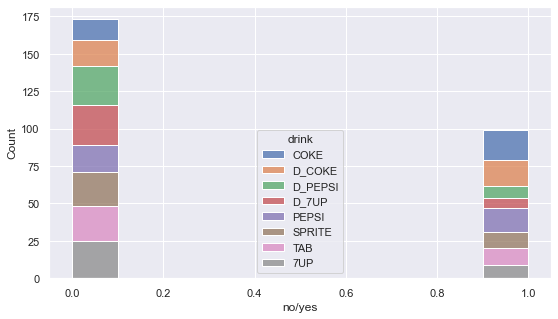

In [404]:
sns.histplot(
    data=df.melt(var_name='drink', value_name='no/yes'),
    x='no/yes',
    hue='drink',
    multiple='stack'
);

Набор данных содержит информацию об факте употреблении опрошенными одного из видов газированных напитков:
- `COKE` - Coca-Cola
- `D_COKE` - диетическая Coca-Cola
- `PEPSI` - Pepsi-Cola
- `D_PEPSI` - диетическая Pepsi-Cola
- `7UP` - 7up
- `D_7UP` - диетический 7up
- `SPRITE` - Sprite
- `TAD` - минеральная вода

## Иерархическая кластеризация

In [405]:
link = hierarchy.linkage(df, 'ward', 'euclidean')

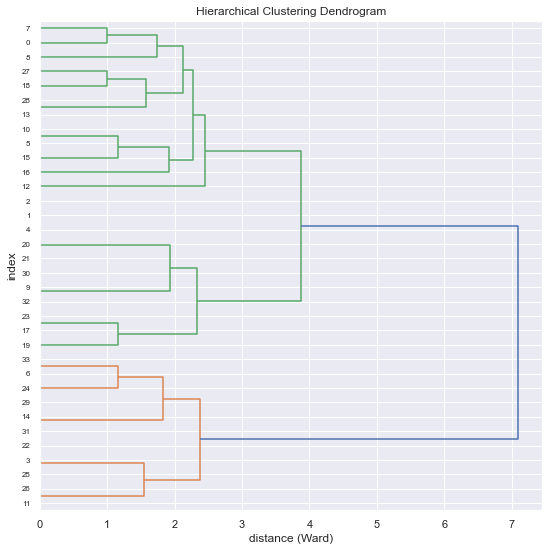

In [406]:
_, ax = plt.subplots(figsize=(9, 9))

dn = hierarchy.dendrogram(link, labels=df.index, orientation='right', ax=ax)
plt.title('Hierarchical Clustering Dendrogram')
plt.ylabel('index')
plt.xlabel('distance (Ward)');

Визуально можно выделить решение состоящее из 3-х кластеров: 7-12, 20-19, 33-11

_Диапазоны индексов указаны согласно графику и на самом деле диапазонами не являются_

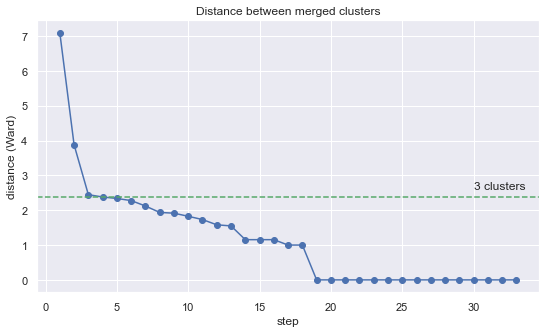

In [407]:
dist_rev = link[:, 2][::-1]

plt.plot(np.arange(1, len(dist_rev) + 1), dist_rev, marker='o')
plt.title('Distance between merged clusters')
plt.xlabel('step')
plt.ylabel('distance (Ward)')
plt.axhline(dist_rev[3], c='g', linestyle='dashed')
plt.text(
    len(link) - 3,
    dist_rev[3] + (dist_rev.max() - dist_rev.min()) / len(dist_rev),
    '3 clusters'
);

In [408]:
df['hierarchy_cluster'] = hierarchy.fcluster(link, 3, criterion='maxclust')

In [409]:
df.groupby('hierarchy_cluster').size()

hierarchy_cluster
1    11
2    11
3    12
dtype: int64

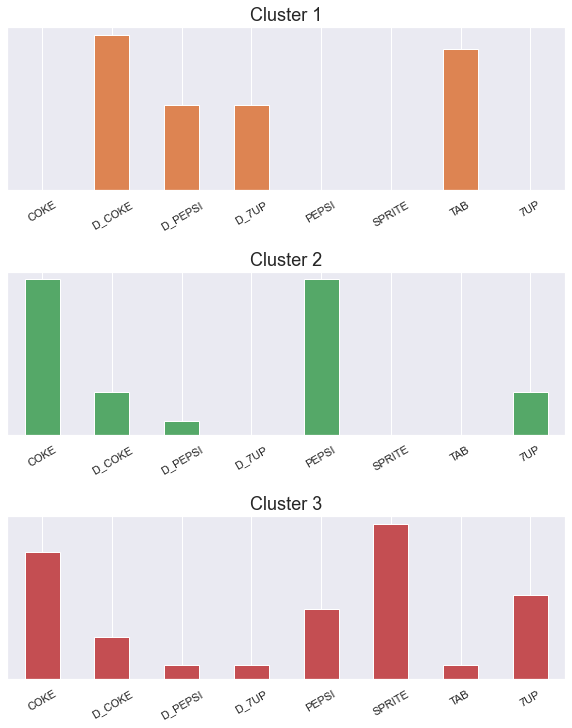

In [410]:
stat = df.groupby('hierarchy_cluster').sum()

fig, axs = plt.subplots(3, 1, figsize=(10, 12))
fig.subplots_adjust(hspace=0.5)
for i, ax in enumerate(axs, start=1):
    ax.set_title(f'Cluster {i}', size=18)
    stat.loc[i, :].plot.bar(ax=ax, rot=30, yticks=None, color=sns.color_palette()[i])
    ax.yaxis.set_visible(False)

Интерпретация кластерного распределения:
1. Потребители диетических напитков и минеральной воды (за ЗОЖ)
2. Фанаты вкуса колы (потребляют Coca-Cola и Pepsi-Cola)
3. Потребляют любую сладкую воду; отдают небольшое предпочтение бесцветным напиткам Sprite и 7UP, уважают классическую колу

## Кластеризация k-means

In [411]:
X = df.drop(columns=['hierarchy_cluster'])

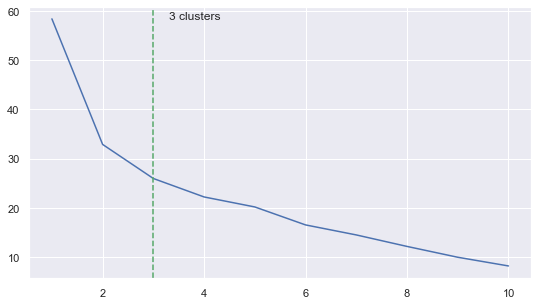

In [412]:
n_clusters = np.arange(1, 11, dtype=int)
wcss = []  # внутрикластерные суммы квадратов
for n in n_clusters:
    k_means = KMeans(n_clusters=n, random_state=0)
    k_means.fit(X)
    wcss.append(k_means.inertia_)

sns.lineplot(x=n_clusters, y=wcss)
plt.axvline(n_clusters[2], c='g', linestyle='dashed')
plt.text(
    n_clusters[2] + 0.3,
    np.max(wcss),
    '3 clusters'
);

В "локтевом образовании" находится оптимальное число кластеров. Здесь это одно из значений: `[2, 3, 4]`

In [413]:
k_means = KMeans(n_clusters=3, random_state=0)
y_means = k_means.fit_predict(X)

In [414]:
df['kmeans_cluster'] = y_means

In [415]:
df.groupby('kmeans_cluster').size()

kmeans_cluster
0     9
1    11
2    14
dtype: int64

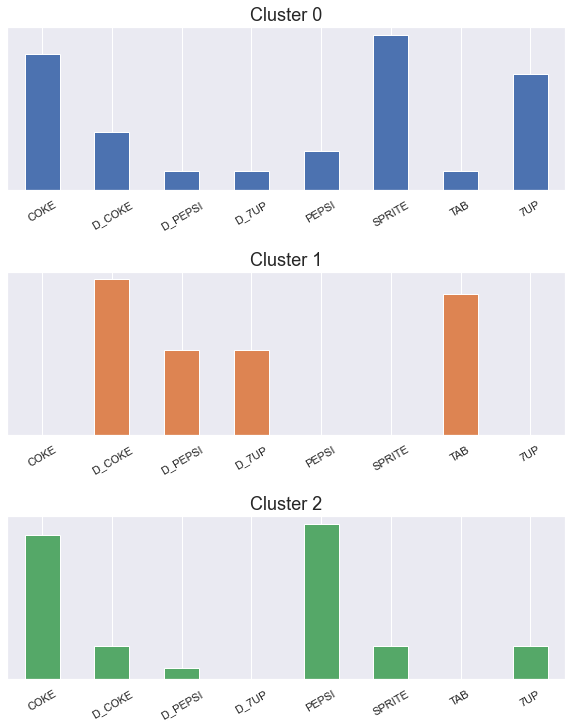

In [416]:
stat = df.drop(columns=['hierarchy_cluster']).groupby('kmeans_cluster').sum()

fig, axs = plt.subplots(3, 1, figsize=(10, 12))
fig.subplots_adjust(hspace=0.5)
for i, ax in enumerate(axs):
    ax.set_title(f'Cluster {i}', size=18)
    stat.loc[i, :].plot.bar(ax=ax, rot=30, yticks=None, color=sns.color_palette()[i])
    ax.yaxis.set_visible(False)

Разделение на кластеры получилось почти аналогичным полученному иерархическим методом.

Кластер диетическими газировками и минеральной водой значительно выделяется на фоне двух других. А вот их различия и интерпретация под вопросом, поэтому попробуем с помощью метрик подобрать оптимальное число кластеров (возможно это будет 2).

### Подбор оптимального количества кластеров

Для оценки будем использовать метрику Силуэта и индекс Калински-Харабаса:

In [417]:
param_grid = [{
    'n_clusters': np.arange(2, 6, dtype=int)
}]

search = GridSearchCV(
    KMeans(random_state=0),
    param_grid,
    scoring={
        'silhouette_score': metrics.make_scorer(metrics.silhouette_score),
        'calinski_harabasz_score': metrics.make_scorer(metrics.calinski_harabasz_score),
    },
    refit='silhouette_score',
    cv=[(slice(None), slice(None))],  # отключаем кросс-валидацию
    n_jobs=4,
)

In [418]:
search.fit(X, X);

In [419]:
score_1 = 'mean_test_calinski_harabasz_score'
score_2 = 'mean_test_silhouette_score'

report = pd.DataFrame(search.cv_results_)
report = report[['param_n_clusters', score_1, score_2, 'mean_fit_time', 'mean_score_time']]
report

,param_n_clusters,mean_test_calinski_harabasz_score,mean_test_silhouette_score,mean_fit_time,mean_score_time
0,2,24.821327,0.404066,0.017000,0.096999
1,3,19.360004,0.350186,0.016998,0.108002
2,4,16.284006,0.348670,0.035801,0.005999
3,5,13.722940,0.294455,0.036797,0.007004


По результатам оценки оптимальным числом для количества кластеров оказалось 2.

In [420]:
k_means = KMeans(n_clusters=2, random_state=0)
y_means = k_means.fit_predict(X)

In [421]:
df['kmeans_optimum_cluster'] = y_means

In [422]:
df.groupby('kmeans_optimum_cluster').size()

kmeans_optimum_cluster
0    21
1    13
dtype: int64

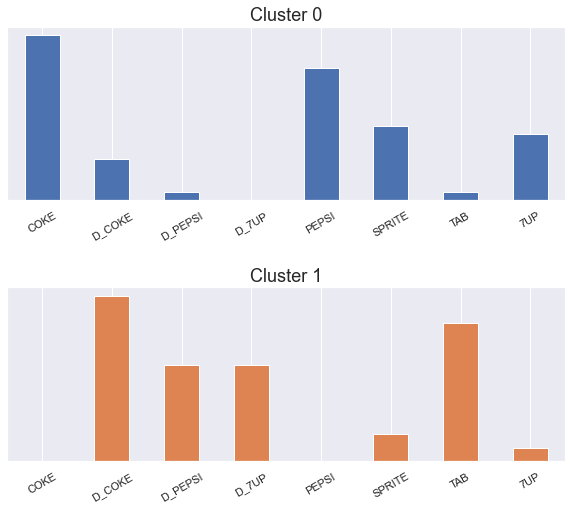

In [423]:
stat = df.drop(columns=['hierarchy_cluster', 'kmeans_cluster']).groupby('kmeans_optimum_cluster').sum()

fig, axs = plt.subplots(2, 1, figsize=(10, 8))
fig.subplots_adjust(hspace=0.5)
for i, ax in enumerate(axs):
    ax.set_title(f'Cluster {i}', size=18)
    stat.loc[i, :].plot.bar(ax=ax, rot=30, yticks=None, color=sns.color_palette()[i])
    ax.yaxis.set_visible(False)

Интерпретация кластеров:
1. Потребители, отдающие предпочтение классическим (более сладким) газировкам.
2. Потребители, предпочитающие диетические газировки или минеральную воду (за ЗОЖ)

In [424]:
df: pd.DataFrame = pd.read_csv('data/assess.dat', sep='\t')
df = df.drop(columns=['NR'])
X = df[[f'T{i}' for i in range(1, 11)]]
X.head()

,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10
0,10,10,9,10,10,10,9,10,10,9
1,10,10,4,10,5,5,4,5,4,3
2,5,4,10,5,10,4,10,5,3,10
3,10,10,9,10,10,10,9,10,10,9
4,4,3,5,4,3,10,4,10,10,5


In [425]:
cols_map = {
    'T1': 'память на числа',
    'T2': 'умение решать математические задачи',
    'T3': 'находчивость на прямом диалоге',
    'T4': 'умение составлять алгоритмы',
    'T5': 'уверенность во время выступления',
    'T6': 'командный дух',
    'T7': 'находчивость',
    'T8': 'сотрудничество',
    'T9': 'признание в коллективе',
    'T10': 'сила убеждения',
}

## Иерархическая кластеризация

In [426]:
link = hierarchy.linkage(X, 'ward', 'euclidean')

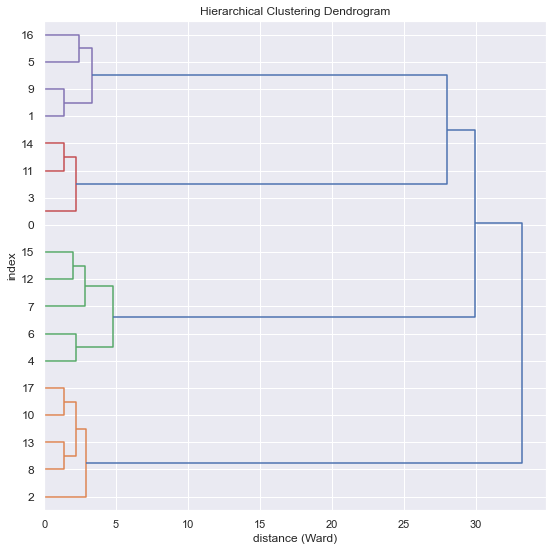

In [427]:
_, ax = plt.subplots(figsize=(9, 9))

dn = hierarchy.dendrogram(link, labels=X.index, orientation='right', ax=ax)
plt.title('Hierarchical Clustering Dendrogram')
plt.ylabel('index')
plt.xlabel('distance (Ward)');

Визуально можно наблюдать хорошее разделение на 4 кластера: 16-1, 14-0, 15-4, 17-2

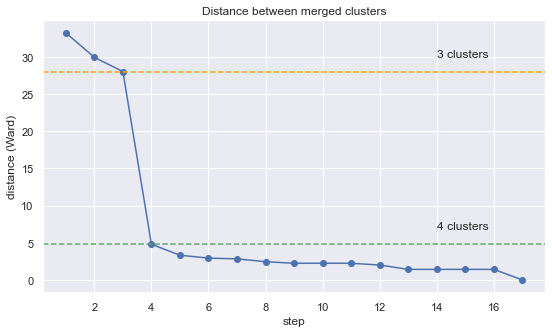

In [428]:
dist_rev = link[:, 2][::-1]

plt.plot(np.arange(1, len(dist_rev) + 1), dist_rev, marker='o')
plt.title('Distance between merged clusters')
plt.xlabel('step')
plt.ylabel('distance (Ward)')
plt.axhline(dist_rev[2], c='orange', linestyle='dashed')
plt.axhline(dist_rev[3], c='g', linestyle='dashed')
plt.text(
    len(link) - 3,
    dist_rev[2] + (dist_rev.max() - dist_rev.min()) / len(dist_rev),
    '3 clusters'
)
plt.text(
    len(link) - 3,
    dist_rev[3] + (dist_rev.max() - dist_rev.min()) / len(dist_rev),
    '4 clusters'
);

In [429]:
X['hierarchy_cluster_3'] = hierarchy.fcluster(link, 3, criterion='maxclust')

In [430]:
X.groupby('hierarchy_cluster_3').size()

hierarchy_cluster_3
1    5
2    5
3    8
dtype: int64

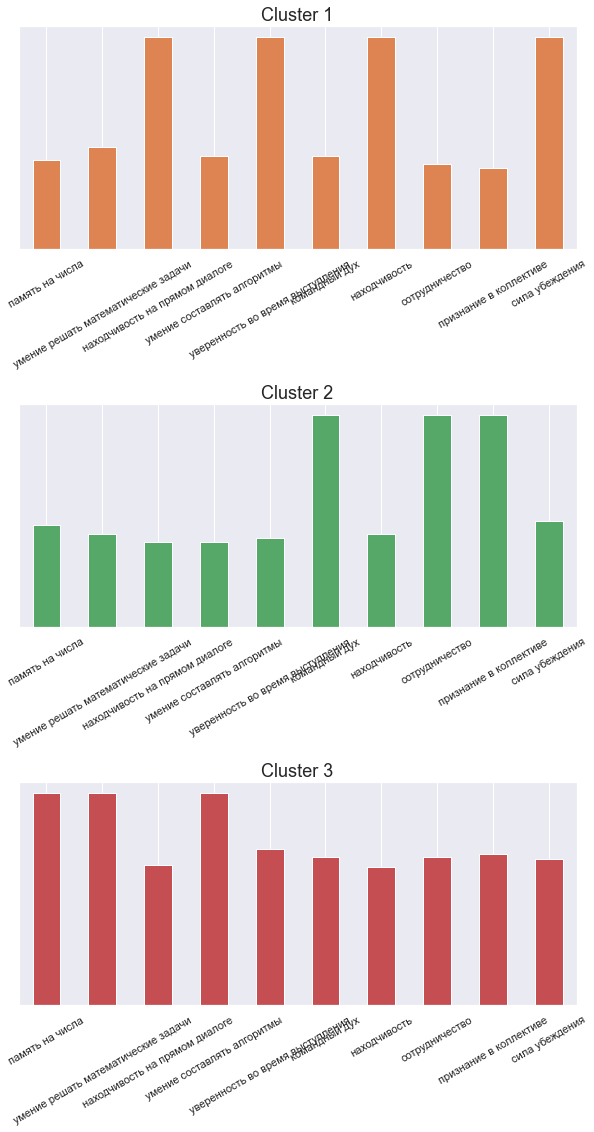

In [431]:
stat = X.groupby('hierarchy_cluster_3').sum().rename(columns=cols_map)

fig, axs = plt.subplots(3, 1, figsize=(10, 18))
fig.subplots_adjust(hspace=0.7)
for i, ax in enumerate(axs, start=1):
    ax.set_title(f'Cluster {i}', size=18)
    stat.loc[i, :].plot.bar(ax=ax, rot=30, yticks=None, color=sns.color_palette()[i])
    ax.yaxis.set_visible(False)

По результатам разделения на 3 кластера мы получили следующие группы:
1. Находчивые, уверенные и общительные люди (менеджеры, руководители)
2. "Командные игроки" - преобладает командный дух, признание в коллективе, сотрудничество
3. Люди с "математическим складом ума" _(странно, что они думают у них также неплохо развиты все остальные социальные навыки😞)_

## Кластеризация k-means

In [432]:
X = X.drop(columns=['hierarchy_cluster_3'])

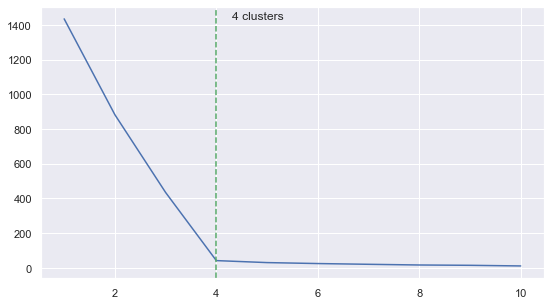

In [433]:
n_clusters = np.arange(1, 11, dtype=int)
wcss = []  # внутрикластерные суммы квадратов
for n in n_clusters:
    k_means = KMeans(n_clusters=n, random_state=0)
    k_means.fit(X)
    wcss.append(k_means.inertia_)

sns.lineplot(x=n_clusters, y=wcss)
plt.axvline(n_clusters[3], c='g', linestyle='dashed')
plt.text(
    n_clusters[3] + 0.3,
    np.max(wcss),
    '4 clusters'
);

 В "локтевом образовании" находятся точки 3 и 4. Так как для иерархической кластеризации мы брали 3 кластера, то методом k-means попробуем выделить 4 группы.

In [434]:
k_means = KMeans(n_clusters=4, random_state=0)
y_means = k_means.fit_predict(X)

In [435]:
X['kmeans_cluster_4'] = y_means

In [436]:
X.groupby('kmeans_cluster_4').size()

kmeans_cluster_4
0    5
1    5
2    4
3    4
dtype: int64

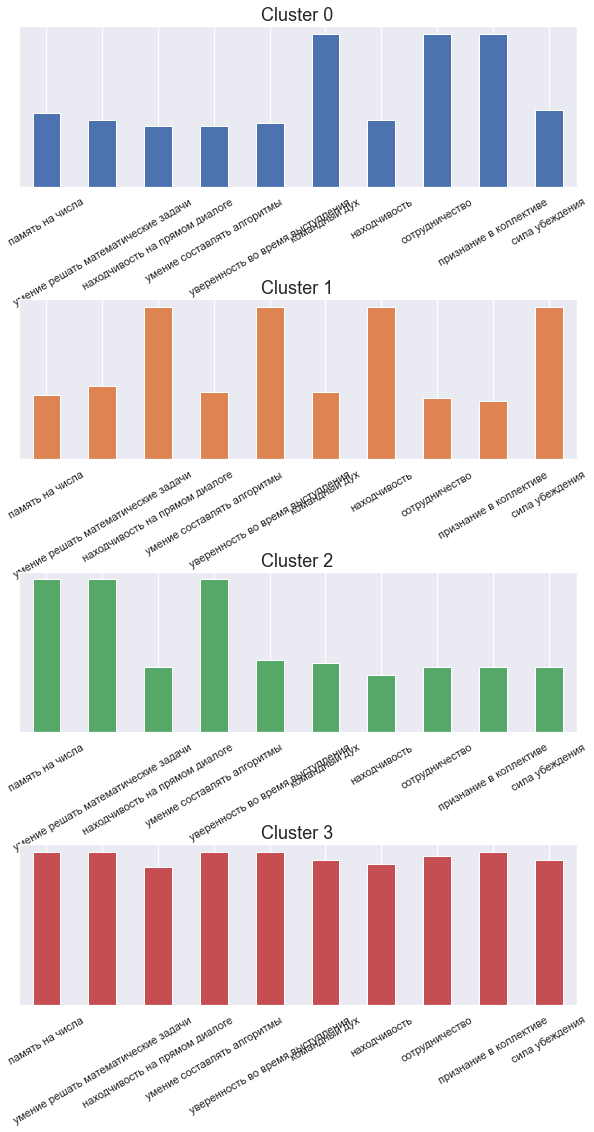

In [437]:
stat = X.groupby('kmeans_cluster_4').sum().rename(columns=cols_map)

fig, axs = plt.subplots(4, 1, figsize=(10, 18))
fig.subplots_adjust(hspace=0.7)
for i, ax in enumerate(axs):
    ax.set_title(f'Cluster {i}', size=18)
    stat.loc[i, :].plot.bar(ax=ax, rot=30, yticks=None, color=sns.color_palette()[i])
    ax.yaxis.set_visible(False)

Разделение на 4 кластера дало нам помимо 3-х тех же групп еще одну:
1. "Командные игроки"
2. Менеджеры и руководители
3. Думают, что что-то понимают в математике
4. Люди без суперспособностей

Разделение на 4 кластера позволяет отделить от группы математиков обычных людей, при этом распределения кластеров 1 и 2 не изменяются.

### Подбор оптимального количества кластеров

In [438]:
param_grid = [{
    'n_clusters': [3, 4]
}]

search = GridSearchCV(
    KMeans(random_state=0),
    param_grid,
    scoring={
        'silhouette_score': metrics.make_scorer(metrics.silhouette_score),
        'calinski_harabasz_score': metrics.make_scorer(metrics.calinski_harabasz_score),
    },
    refit='silhouette_score',
    cv=[(slice(None), slice(None))],  # отключаем кросс-валидацию
    n_jobs=4,
)

In [439]:
X = X.drop(columns=['kmeans_cluster_4'])

In [440]:
search.fit(X, X);

In [441]:
score_1 = 'mean_test_calinski_harabasz_score'
score_2 = 'mean_test_silhouette_score'

In [442]:
report = pd.DataFrame(search.cv_results_)
report = report[['param_n_clusters', score_1, score_2, 'mean_fit_time', 'mean_score_time']]
report

,param_n_clusters,mean_test_calinski_harabasz_score,mean_test_silhouette_score,mean_fit_time,mean_score_time
0,3,17.269744,0.616452,0.018003,0.004000
1,4,155.466241,0.836281,0.015004,0.005001


**Вывод:** по результатам оценки разделение на 4 кластера оказывается более эффективным. Так же такое разделение позволяет выявить "настоящих математиков", что может быть хорошим решением, например, перед распределением специальных задач.